# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2022-2023, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Ruben Martin Rodriguez (R.MartinRodriguez@student.tudelft.nl)
* (c) TU Delft, 2023

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Jasper Boogers"
STUDENT_1_STUDENT_NUMBER = "4591704"
STUDENT_1_NETID = "jboogers"
STUDENT_1_EMAIL = "j.m.boogers@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Problem 3 - Reinforcement Learning (45p)

**Author:** Dr. Zlatan Ajanović (Z.Ajanovic@tudelft.nl)

This exercise focuses on learning control policy without having need for a model, model-free RL. For this purpose, we use simplified version of the robot from problem 2 obtained by removing the second link (i.e., standard pendulum). 


We want to directly learn a control policy $\pi(x)$ for rotating the pendulum to an angle $\theta = \frac{\pi}{2}$ (move it in the upright position), only by interacting with the system. As currently stated, this is a simple task that can be solved by any model-free PD controller (e.g., Task 2.1). To have more fun, we make the problem more challenging by limiting the maximum torque $\tau_\mathrm{max}$ to a value preventing the trivial solution. Even if plenty of analytical solutions exist in the literature, it is quite interesting to see if RL can deal with such a nontrivial control problem without any model. By answering the theoretical questions and implementing their solutions you will construct a temporal difference reinforcement learning solution using the tabular SARSA algorithm.

Analogue to problems 1 & 2, we define the position of the pendulum as the counter-clockwise rotation with respect to the horizontal x-axis, which points towards the right. The y-axis is pointing upwards and gravity is pointing downwards.

Most of the theory needed to answer the questions in this assignment can be found in the book ''Reinforcement Learning: an Introduction'' by Sutton and Barto (S\&B), Chapters 1, 2, 3, 4 and 6. An online version of this book can be found here: [RL book](http://incompleteideas.net/book/the-book.html). You can also look at the lecture slides.


The complete code for this exercise is available in this Jupyter notebook (except the pendulum model and some libraries). First, you will implement different components of the RL solution, test and analyze them, and then integrate all the components in the RL framework. Finally, you will analyze RL framework performance and sensitivity to different design decisions. For each of the tasks, you need to implement some part of the code in that section. After that, you can use the test section to visualize and check your implementation.

In [3]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
from distutils.util import strtobool
from functools import partial
from IPython.display import display, HTML  # For animations in the notebook
from jax.config import config as jax_config

jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision
from jax import numpy as jnp
from jax import Array, jit, lax, random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from pathlib import Path
from tqdm.notebook import tqdm  # progress bar
from typing import Callable, Dict, Tuple

from jax_double_pendulum.analysis import *
from jax_double_pendulum.motion_planning import (
    generate_ellipse_trajectory,
    ELLIPSE_PARAMS,
)
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.visualization import animate_robot

from analysis import (
    plot_configuration_space_evolution,
    plot_operational_space_evolution,
)

# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))

# create folder for outputs
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

## Task 3.1 Familiarizing with the code (0p)

Read the complete notebook. 

Think about these questions:

- How many simulation steps are executed in a trial?
- What are all the components of the framework?
- How are they related and which ones depend on each other?
- Compare the structure of the learning loop to SARSA in [RL Book](http://incompleteideas.net/book/ebook/node64.html), Figure 6.9 from the textbook.

## Task 3.2 Setting the learning parameters (3p)

Look at the `SARSA_PARAMS` and set the random action rate `epsilon` to $0.1$, and the learning rate `alpha` to $0.15$ and appropriate discount factor `gamma`.


Learning is faster with higher learning rates. Why would we want to keep it low anyway? 


Set the action discretization to $15$ actions. Set the number of episodes to $8000$. Set the position discretization (i.e. `pos_states`) to $51$. Set the velocity discretization (i.e. `vel_states`) to $51$. Set the maximum pendulum torque to $5$ Nm.


Run the section to make sure that you didn't make any obvious mistakes.

These are not fixed parameters and you will probably spend some time tuning them.


In [4]:
# SARSA learning params
# hint - use dictionary keys: epsilon, gamma, alpha, pos_states, vel_states, actions, episodes, maxtorque

SARSA_PARAMS = {
    "explore": True,  # flag for choosing greedy only or explore
    # YOUR CODE HERE
    "epsilon": 0.1,
    "alpha": 0.15,
    "gamma": 0.1,
    "actions": 15,
    "episodes": 8000,
    "pos_states": 51,
    "vel_states": 51,
    "maxtorque": 5,
}

## Task 3.3 Initialize Q table (2p)

The initial values in your Q table can be very important for the exploration behavior, and there are therefore
many ways of initializing them (see S&B, Section 2.7). This is done in the init_Q(.) function.
- Pick a method and give a short argumentation for your choice.
- Implement your choice. The Q table should be of size N × M × O, where N is the number of
position states, M is the number of velocity states, and O is the number of actions.

Run the test section to find obvious mistakes. The test section should visualize also the first layer of the Q
table. Run this section multiple times.

In [5]:
def init_Q(par: dict) -> Array:
    """
    Initialize the Q table.

    Args:
        par: dictionary of SARSA learning parameters

    Returns:
        Q: Initial Q table of shape (N, M, O)
    """

    # TODO: Initialize the Q table.
    # YOUR CODE HERE
    M = par["pos_states"]
    N = par["vel_states"]
    O = par["actions"]

    Q = 0.5*jnp.ones((N, M, O))
    # Q = Q.at[:,:,0].set(5)

    # raise NotImplementedError()

    return Q

Add your argumentation here (max 50 words):

Since this is a stationary problem (the target state is time independent) and we have prior knowledge of the desired outcome, an optimistic initial value is a suitable method for initializing Q to encourage exploration.

In [6]:
from scipy.ndimage import gaussian_filter


def plot_theta_theta_d(data: Array, par: dict, suptitle: str = None):
    """
    Plot a Value function and optionally also a policy function over the discretized state space
    Args:
        data: array of shape (N, M, O) for plotting Q table or of shape (N, M) for plotting just value function
        par: dictionary of RL parameters
        suptitle: optional title / heading of figure
    """
    n_plot = 20
    scale = 1.0

    xx = jnp.linspace(0, par["pos_states"], num=par["pos_states"] + 1)
    xy = jnp.linspace(0, par["vel_states"], num=par["vel_states"] + 1)

    def format_space_ax(ax):
        x_tick_label = [r"$\pm\pi$", r"$-\pi/2$", r"$0$", r"$+\pi/2$", r"$\pm\pi$"]

        ax.set_xlabel(r"Angle")
        ax.set_ylabel(r"Velocity")
        return ax

    # case of ploting Q function
    if jnp.shape(jnp.shape(data)) == (3,):
        fig = plt.figure(figsize=(12, 4))
        fig.subplots_adjust(
            left=0.05, bottom=0.12, right=1.0, top=0.88, wspace=0.1, hspace=0.3
        )

        ax_val = format_space_ax(fig.add_subplot(1, 2, 1))
        ax_pi = format_space_ax(fig.add_subplot(1, 2, 2))

        ax_val.set_title(r"$V(x)$")
        ax_pi.set_title(r"$\pi(x)$")

        V_mat = jnp.amax(data, axis=2)  # maximum along actions axis
        a_mat = jnp.argmax(data, axis=2)  # maximum along actions axis

        a_mat = gaussian_filter(a_mat, sigma=1)

        cset = ax_pi.pcolormesh(
            xx,
            xy,
            jnp.transpose(a_mat),
            shading="flat",
            vmin=0,
            vmax=par["actions"],
            cmap="seismic",
        )
        plt.colorbar(cset, ax=ax_pi)

    else:  # ploting other functions
        fig = plt.figure(figsize=(6.4, 4.8))

        ax_val = format_space_ax(fig.add_subplot(1, 1, 1))

        V_mat = data

    if suptitle is not None:
        plt.suptitle(suptitle)

    cset = ax_val.pcolormesh(
        xx,
        xy,
        jnp.transpose(V_mat),
        shading="flat",
        vmin=0,
        vmax=jnp.abs(V_mat).max(),
        cmap="plasma",
    )
    plt.colorbar(cset, ax=ax_val)

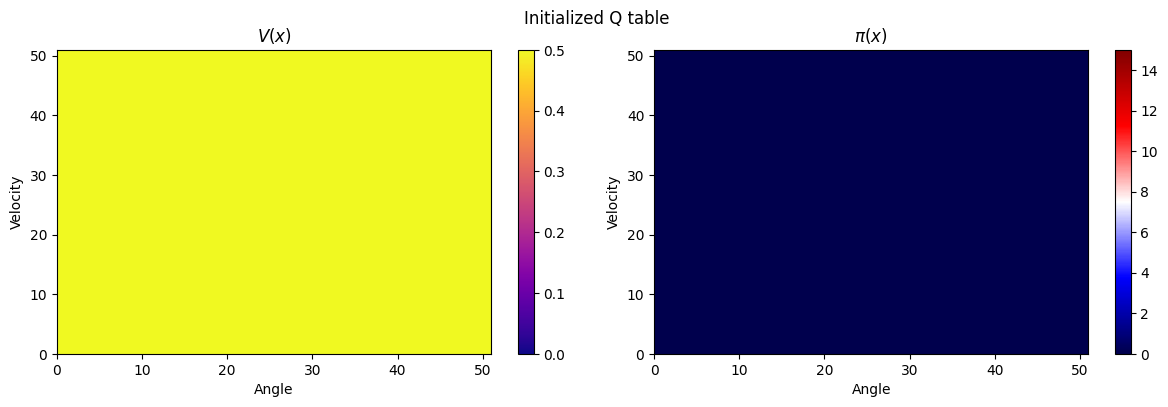

In [7]:
# Test Visualize 1st layerSta

Q = init_Q(
    SARSA_PARAMS,
)

plot_theta_theta_d(Q, SARSA_PARAMS, suptitle="Initialized Q table")

# save the plot
plt.savefig(str(outputs_dir / "task_3-3_initialize_Q_table.pdf"))

## Task 3.4 Discretize state (5p)


In Task 3.2, you determined the number of position and velocity states that your Q table can hold, and the
number of actions the agent can choose from. The state discretization is done in the `discretize_state(.)`
function.
- Implement the position discretization. The input may be outside the interval $[-\pi, \pi]$ rad, so be
sure to wrap the state around (hint: use the mod function). The resulting state must be in the range
`[0, pos_states-1]`. Make sure to perform the mapping such as that $\frac{\pi}{2}$ rad (the “up” position) will be in the center of the discrete range.
- Implement the velocity discretization. Even though we assume that the values will not exceed the
range `[−5π, 5π] rad s−1`, they must be clipped to that range to avoid errors. The resulting state
must be in the range `[0, vel_states-1]`. Make sure to perform the mapping such as that zero velocity will be in the center of the discrete range.
- What would happen if we clip the velocity range too soon, say at `[−2π, 2π] rad/s`?

Run the test section, and look at the plots of continuous vs. discretized position. Are they what you would expect?



In [8]:
@jit
def discretize_state(x: Array, par: Dict) -> Array:
    """
    Discretize the state
    Args:
        x: state in the continuous domain. Float64 array of shape (2, )
        par: Dictionary with parameters
    Returns:
        s: state in the discrete domain. Int64 array of shape (2, )
    """
    # TODO: Discretize state.
    # Note: s[0] should be pendulum position, s[1] velocity.

    # YOUR CODE HERE
    pos, vel = x[0], x[1]
    pos = jnp.mod(pos, jnp.pi)
    vel = jnp.clip(vel, -5*jnp.pi, 5*jnp.pi)

    pos_d = jnp.interp(pos, jnp.array([0, jnp.pi]), jnp.array([0, par["pos_states"]-1]))
    vel_d = jnp.interp(vel, jnp.array([-5*jnp.pi, 5*jnp.pi]), jnp.array([0, par["vel_states"]-1]))

    s = jnp.array([pos_d, vel_d])

    return s.astype(jnp.int64)

s: [25 25]


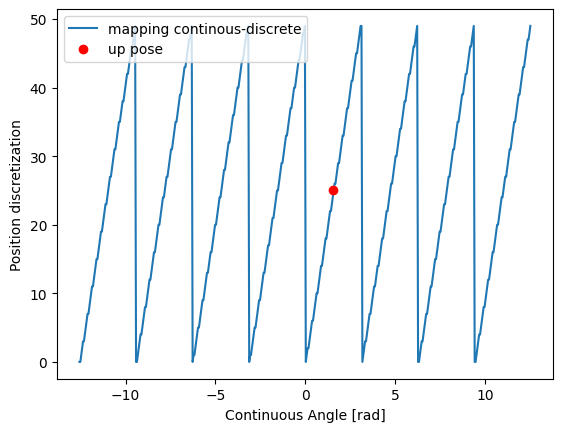

In [9]:
# Test and plot position discretization
x0 = jnp.zeros((2,))
pos_con = jnp.arange(-4 * jnp.pi, 4 * jnp.pi, step=0.05)
pos_dis = jnp.zeros(pos_con.shape)
for pp in range(len(pos_con)):
    x0 = x0.at[0].set(pos_con[pp])
    s = discretize_state(x0, SARSA_PARAMS)
    pos_dis = pos_dis.at[pp].set(s[0])

# test vertical pose
s = discretize_state(jnp.array([jnp.pi / 2, 0]), SARSA_PARAMS)
print("s:", s)

plt.plot(pos_con, pos_dis, label="mapping continous-discrete")
plt.plot(jnp.pi / 2, s[0], "ro", label="up pose")

plt.xlabel(r"Continuous Angle [rad]")
plt.ylabel("Position discretization")
plt.legend(loc="upper left")

# save the plot
plt.savefig(str(outputs_dir / "task_3-4_position_discretization.pdf"))

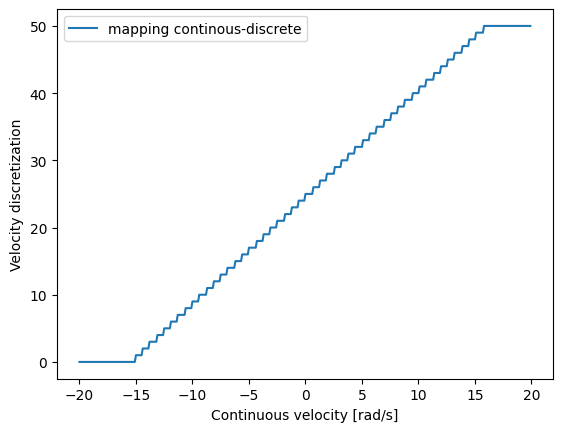

In [10]:
# Test and plot velocity discretization
x0 = jnp.zeros((2,))
vel_con = jnp.arange(-20, 20, 0.1)
vel_dis = jnp.zeros(vel_con.shape)

for vv in range(len(vel_con)):
    x0 = x0.at[1].set(vel_con[vv])
    s = discretize_state(x0, SARSA_PARAMS)
    vel_dis = vel_dis.at[vv].set(s[1])

plt.plot(vel_con, vel_dis, label="mapping continous-discrete")

plt.xlabel(r"Continuous velocity [rad/s]")
plt.ylabel("Velocity discretization")
plt.legend(loc="upper left")

plt.savefig(str(outputs_dir / "task_3-4_velocity_discretization.pdf"))

## Task 3.5 Conversion of actions to torques (2p)

Now you need to specify how the discrete actions are turned into torque values, in the `convert_action_to_torque(.)`
function.
- The allowable torque is in the range `[−maxtorque, maxtorque]`. Distribute the actions
uniformly over this range. This means that zero torque will be in the middle of the range.

Run the test section, and look at the plots of continuous vs. discretized position. Are they what you would
expect?


In [11]:
# Action execution
@jit
def convert_action_to_torque(a: Array, par: Dict) -> Array:
    """
    Convert a discrete action to a continuous, saturated torque, which can be applied to the system
    Args:
        a: discrete action as array of shape ()
        par: Dictionary with parameters
    Returns:
        tau: continuous torque as array of shape ()
    """
    # TODO: Calculate the proper torque for action a.
    # This cannot exceed par["maxtorque"].

    # YOUR CODE HERE
    maxtau = par["maxtorque"]
    tau = jnp.interp(a, jnp.array([0, par["actions"]-1]), jnp.array([0, maxtau]))

    return tau

Torques:
 [0.         0.35714286 0.71428571 1.07142857 1.42857143 1.78571429
 2.14285714 2.5        2.85714286 3.21428571 3.57142857 3.92857143
 4.28571429 4.64285714 5.        ]


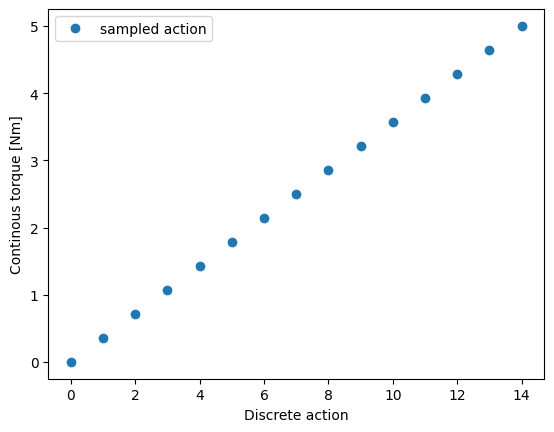

In [12]:
# test
torque_dis = jnp.zeros(SARSA_PARAMS["actions"])

for aa in range(SARSA_PARAMS["actions"]):
    torque = convert_action_to_torque(aa, SARSA_PARAMS)
    torque_dis = torque_dis.at[aa].set(torque)

print("Torques:\n", torque_dis)

plt.plot(torque_dis, "o", label="sampled action")

plt.xlabel(r"Discrete action")
plt.ylabel("Continous torque [Nm]")
plt.legend(loc="upper left")
plt.savefig(str(outputs_dir / "task_3-5_action_to_torque.pdf"))

## Task 3.6. Reward design (3p)

Now you should determine the reward function, which is implemented in `observe_reward(.)`.
- What is the simplest reward function that you can devise, given that we want the system to balance
the pendulum at the top?
- Implement `observe_reward(.)` function.
- **Hint:** If you need to express conditions, use [`lax.select`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.select.html) instead of `if` clauses, as pythonic `if` conditions are not jittable.

Run the test section, and verify in the plot that you have indeed implemented the reward function you
wanted.

In [13]:
@jit
def observe_reward(a: Array, sP: Array, par: Dict) -> float:
    """
    Distributes a reward for the action `a` resulting in state `sP`.
    Remember that the goal is to swing-up the pendulum to a link angle of $\frac{\pi}{2}$.
    Args:
        a: discrete action as array of shape ()
        sP: state resulting from taking the action `a` as array of shape (2, )
    Returns:
        r: reward for the state-action pair
    """
    # TODO: Calculate the reward for taking action a, resulting in state sP.

    # YOUR CODE HERE
    # up = jnp.append(sP, a)
    up = sP
    cond = jnp.allclose(up, jnp.array([25, 25]))
    r = lax.select(cond, 1, 0)

    return r

  0%|          | 0/2601 [00:00<?, ?it/s]

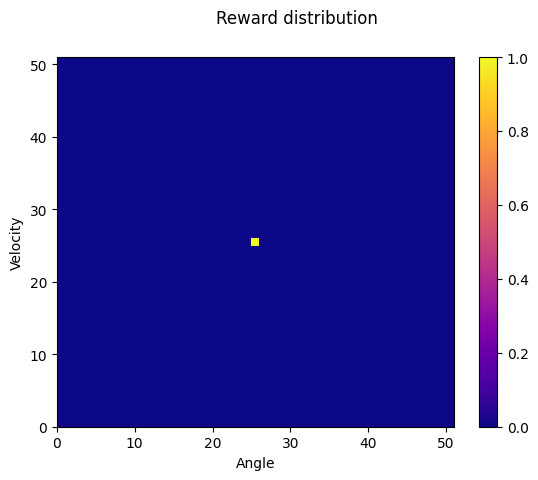

In [14]:
# Test
# Attention: ignore the figure titles! Only reusing the plot function for the Q.

# initialize array with reward distribution
r_dist = jnp.zeros(
    (SARSA_PARAMS["pos_states"], SARSA_PARAMS["vel_states"], SARSA_PARAMS["actions"])
)

pbar = tqdm(total=SARSA_PARAMS["pos_states"] * SARSA_PARAMS["vel_states"])
for pp in range(SARSA_PARAMS["pos_states"]):
    for vv in range(SARSA_PARAMS["vel_states"]):
        for aa in range(SARSA_PARAMS["actions"]):
            # state
            s = jnp.array([pp, vv])

            # observe reward
            r = observe_reward(aa, s, SARSA_PARAMS)

            # insert reward for current state-action pair
            r_dist = r_dist.at[pp, vv, aa].set(r)

        pbar.update(1)

pbar.close()

rm = jnp.mean(r_dist, axis=2)

# plot the reward distribution
plot_theta_theta_d(rm, SARSA_PARAMS, suptitle="Reward distribution")

# save the figure
plt.savefig(str(outputs_dir / "task_3-6_reward_distribution.pdf"))

In [15]:
x0 = jnp.array([jnp.pi / 2, 0])
s = discretize_state(x0, SARSA_PARAMS)
r_t = observe_reward(aa, s, SARSA_PARAMS)

x1 = jnp.array([0.9 * jnp.pi / 2, 0])
s1 = discretize_state(x1, SARSA_PARAMS)

r_1 = observe_reward(aa, s1, SARSA_PARAMS)

assert r_t > r_1

x1 = jnp.array([1.1 * jnp.pi / 2, 0])
s1 = discretize_state(x1, SARSA_PARAMS)

r_1 = observe_reward(aa, s1, SARSA_PARAMS)

assert r_t > r_1

##  Task 3.7. Episode termination (3p)

You also need to implement a criterium for stopping the episode. While we could learn to continually
balance the pendulum, in this exercise we will only learn to swing up into a balanced state, so-called
episodic learning. The trial can therefore be ended when that goal state is reached.

**Hint:** If you need to express conditions, use [`lax.select`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.select.html) instead of `if` clauses, as pythonic `if` conditions are not jittable.

In [16]:
@jit
def is_terminal(sP: Array, par: Dict) -> int:
    """
    Criterium for stopping the episode
    Args:
        sP: state as array of shape (2, )
        par: Dictionary with parameters
    Returns:
        t: scalar indicating whether the episode should be stopped (1) or be continued (0)
    """

    # TODO: Return 1 if state sP is terminal, 0 otherwise.
    # YOUR CODE HERE
    cond = jnp.allclose(sP, jnp.array([25, 25]))
    t = lax.select(cond, 1, 0)

    return t

  0%|          | 0/2601 [00:00<?, ?it/s]

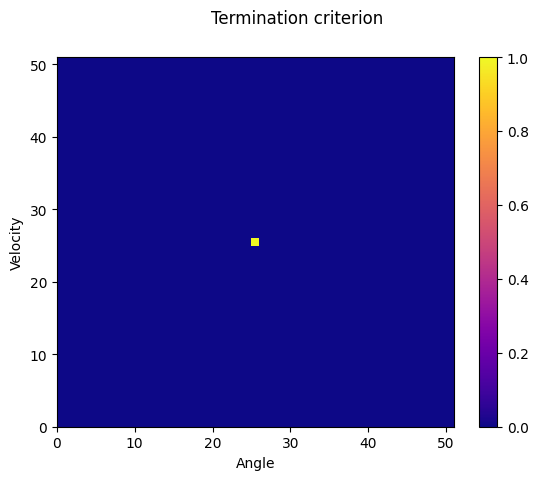

In [17]:
# Test
# Attention: ignore the figure titles! Only reusing the plot function for the Q.

t_dist = jnp.zeros((SARSA_PARAMS["pos_states"], SARSA_PARAMS["vel_states"]))

pbar = tqdm(total=SARSA_PARAMS["pos_states"] * SARSA_PARAMS["vel_states"])
for pp in range(SARSA_PARAMS["pos_states"]):
    for vv in range(SARSA_PARAMS["vel_states"]):
        # state
        s = jnp.array([pp, vv])

        # evaluate the termination criterion for the current state
        t = is_terminal(s, SARSA_PARAMS)

        # store terminal condition
        t_dist = t_dist.at[pp, vv].set(t)

        pbar.update(1)
pbar.close()

plot_theta_theta_d(t_dist, SARSA_PARAMS, suptitle="Termination criterion")

# save the figure
plt.savefig(str(outputs_dir / "task_3-7_termination_criterion.pdf"))

## Task 3.8. The policy selection (2p)

It is time to implement the action selection rule in `evaluate_policy(.)` function. See S&B, Sections
2.2 and 6.4.
- Implement the greedy action selection algorithm.
- Modify the chosen action according to the ε-greedy policy. Hint: use the rand and randint
functions.
- **Hint:** If you need to express conditions, use [`lax.select`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.select.html) instead of `if` clauses, as pythonic `if` conditions are not jittable.

Run the test section to check for errors.

In [18]:
@jit
def evaluate_policy(
    Q: Array, s: Array, par: Dict, rng: random.KeyArray
) -> Tuple[Array, random.KeyArray]:
    """
    Evaluate the policy and choose a discrete action.
    Args:
        Q: Q table of shape (N, M, O)
        s: state as array of shape (2, )
        par: Dictionary with parameters
        rng: PRNG key for pseudo-random number generation.
    Returns:
        a: discrete action as array of shape ()
        rng: updated PRNG key for pseudo-random number generation.
    """
    # Hint: use the functions random.uniform(.) and random.randint (.)

    rng, rng_exploration, rng_action = random.split(rng, 3)
    eps = random.uniform(rng_exploration, minval=0, maxval=1)
    exploration = random.randint(rng_action, (), minval=0, maxval=par["actions"])
    greedy = jnp.argmax(Q[s[0],s[1],:])
    a = lax.select(
        par["explore"],
        lax.select(eps < par["epsilon"], exploration, greedy),
        greedy
    )
    return a, rng

In [19]:
key = random.PRNGKey(758493)

pbar = tqdm(
    total=SARSA_PARAMS["pos_states"]
    * SARSA_PARAMS["vel_states"]
    * SARSA_PARAMS["actions"]
)
for pp in range(SARSA_PARAMS["pos_states"]):
    for vv in range(SARSA_PARAMS["vel_states"]):
        # define state
        s = jnp.array([pp, vv])

        for aa in range(SARSA_PARAMS["actions"]):
            a, key = evaluate_policy(Q, s, SARSA_PARAMS, key)

            if a < 0 or a > SARSA_PARAMS["actions"]:
                print("Action out of the bound")

            pbar.update(1)
pbar.close()

  0%|          | 0/39015 [00:00<?, ?it/s]

In [20]:
# Test 2
Q1 = Q

key = random.PRNGKey(758493)

opt_action = 2
Q1 = Q1.at[5, 5, opt_action].set(100)
count_greedy = 0
count_random = 0
test_count = 10000

pbar = tqdm(total=test_count)
for i in range(test_count):
    a, key = evaluate_policy(Q1, jnp.array([5, 5]), SARSA_PARAMS, key)
    if a == opt_action:
        count_greedy = count_greedy + 1
    else:
        count_random = count_random + 1
    pbar.update(1)
pbar.close()

count_greedy_ref = (
    1 - SARSA_PARAMS["epsilon"] + SARSA_PARAMS["epsilon"] * 1 / SARSA_PARAMS["actions"]
)

assert (
    count_greedy / test_count > 0.9 * count_greedy_ref
    and count_greedy / test_count < 1.1 * count_greedy_ref
)

  0%|          | 0/10000 [00:00<?, ?it/s]

## Task 3.9. Value update rule (4p)

In this task, you should implement the SARSA update rule in the `update_Q(.)` function.

In [22]:
@jit
def update_Q(
    Q: Array, s: Array, a: Array, r: Array, sP: Array, aP: Array, par: Dict
) -> Array:
    """
    Update the Q-function after one learning iteration, e.g. using SARSA.
    Args:
        Q: Q table of shape (N, M, O)
        s: discrete state as an array of shape (2, )
        a: discrete action as an array of shape ()
        r: reward as a float variable
        sP: discrete state in the next step as an array of shape (2, )
        ap: discrete action in the next step as an array of shape ()
        par: dictionary with parameters
    Returns:
        Q: updated Q table of shape (N, M, O)
    """

    # YOUR CODE HERE
    update = Q[s[0], s[1], a] + par["alpha"]*(r + par["gamma"]*Q[sP[0], sP[1], aP] - Q[s[0], s[1], a])
    Q = Q.at[s[0], s[1], a].set(update)

    return Q

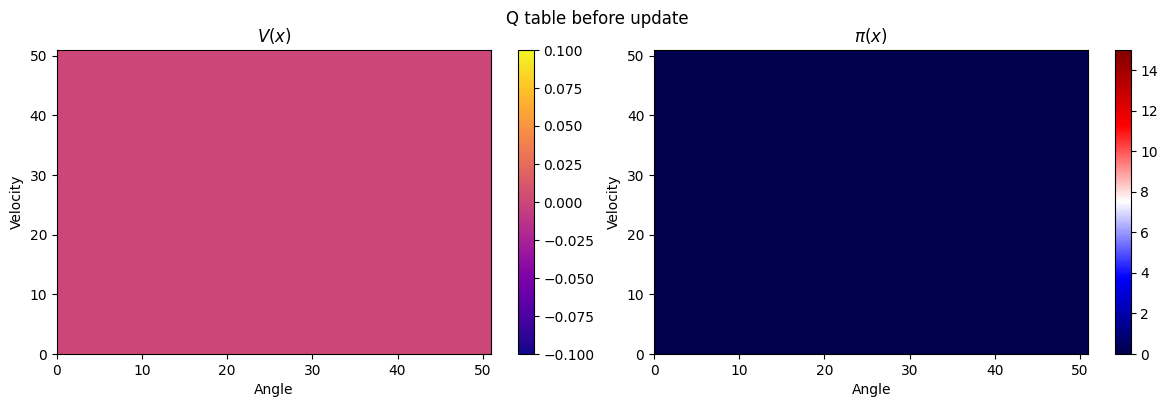

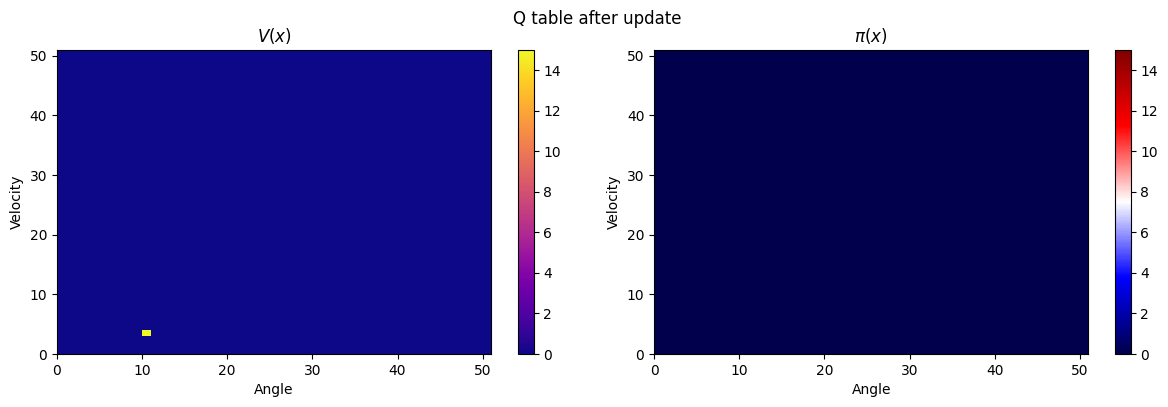

In [23]:
# Testing value update (note that policy plot is blured)

# initial Q table
Q_test = jnp.zeros(
    (SARSA_PARAMS["pos_states"], SARSA_PARAMS["vel_states"], SARSA_PARAMS["actions"])
)

# plot the initial Q table
plot_theta_theta_d(Q_test, SARSA_PARAMS, suptitle="Q table before update")
plt.savefig(str(outputs_dir / "task_3-9_Q_table_before_update.pdf"))

s = jnp.array([10, 3])
sP = jnp.array([10, 2])

# update the Q table
Q_test = update_Q(Q=Q_test, s=s, a=2, r=100, sP=sP, aP=2, par=SARSA_PARAMS)

# plot the updated Q table
plot_theta_theta_d(Q_test, SARSA_PARAMS, suptitle="Q table after update")
# save the figure
plt.savefig(str(outputs_dir / "task_3-9_Q_table_after_update.pdf"))

## Task 3.10. Make it work (12p)

Finally, implement SARSA as described in [RL Book](http://incompleteideas.net/book/ebook/node64.html), Figure 6.9 and complete all the code of the learning loop (initializations of outer and inner loops, calculation of torque, learning and termination). Basically, you need to call all functions prepared in Tasks 3.3-3.9 in the right order. Also, make sure that the initial state is always slightly perturbed, i.e., that `sample_initial_state(.)` is used for initialization.

After that, run the training section and see how your learning algorithm behaves! Run animation and check the performance. 

### Task 3.10.1: Initialize pendulum (2p)

Here you should implement the strategy to initialize the pendulum at the start of each episode.

In [24]:
@jit
def sample_initial_state(rng: random.KeyArray) -> Tuple[Array, random.KeyArray]:
    """
    Randomly sample the initial state of the pendulum
    Args:
        rng: PRNG key for pseudo-random number generation.
    Returns:
        x0: initial state of the pendulum as an array of shape (2, )
        rng: updated PRNG key for pseudo-random number generation.
    """
    # TODO Set initial state for the experiment, cover the whole state-space
    # Hint: make sure to split the PRNG into three new keys
    #       the first key should be returned again by the function
    #       the other two keys can be used for the random sampling of the initial state
    # Hint: use random.uniform

    # YOUR CODE HERE
    rng, rng1, rng2 = random.split(rng, 3)
    pos = random.uniform(rng1, minval=-1*jnp.pi, maxval=jnp.pi)
    vel = random.uniform(rng2, minval=-5*jnp.pi, maxval=5*jnp.pi)
    x0 = jnp.array((pos, vel))

    return x0, rng

  0%|          | 0/1000 [00:00<?, ?it/s]

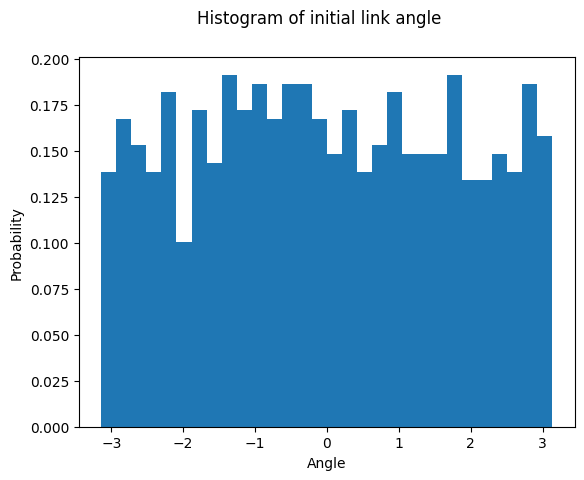

In [25]:
# test
test_size = 1000
x0_dist = jnp.zeros([2, test_size])
for i in (pbar := tqdm(range(test_size))):
    x0, key = sample_initial_state(key)
    x0_dist = x0_dist.at[:, i].set(x0)

plt.hist(x0_dist[0, :], density=True, bins=30)  # density=False would make counts
plt.suptitle("Histogram of initial link angle")
plt.ylabel("Probability")
plt.xlabel("Angle")

# save the figure
plt.savefig(str(outputs_dir / "task_3-10-1_histogram_of_initial_state.pdf"))

### Pendulum model

As our simulator is implemented for a double pendulum, we have to simulate two links. However, we will choose the parameters of the 2nd link such that there are only neglible dynamical effects on the first link.

In [26]:
ROBOT_PARAMS_SINGLE = dict(
    l1=1,  # Length of link 1 [m]
    lc1=1,  # Distance of CoM of link 1 from base [m]
    m1=2,  # Mass of link 1 [kg]
    j1=1 / 15 * 2 * 1**2,  # Inertia of link 1 [kg*m^2] about its CoM
    l2=1e-2,  # Length of link 2 [m]
    lc2=1e-2,  # Distance of CoM of link 2 from elbow [m]
    m2=1e-2,  # Mass of link 2 [kg]
    j2=1e-2,  # Inertia of link 2 [kg*m^2] about its CoM
    g=9.81,  # Gravitational acceleration [m/s^2]
)

dt = 5e-2  # time step [s]

In [27]:
# Animate pendulum

# initial state of the single pendulum
s_0 = jnp.array([jnp.pi / 4, 0.0])

# convert single pendulum state to double state
th_0 = jnp.array([s_0[0], 0.0])
th_d_0 = jnp.array([s_0[1], 0.0])

sim_duration = 10.0  # simulation duration [s]

t_ts = dt * jnp.arange(int(sim_duration / dt))

sim_ts = simulate_robot(
    rp=ROBOT_PARAMS_SINGLE,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=th_d_0,
    tau_ext_ts=jnp.array([10.0, 0.0]),
)

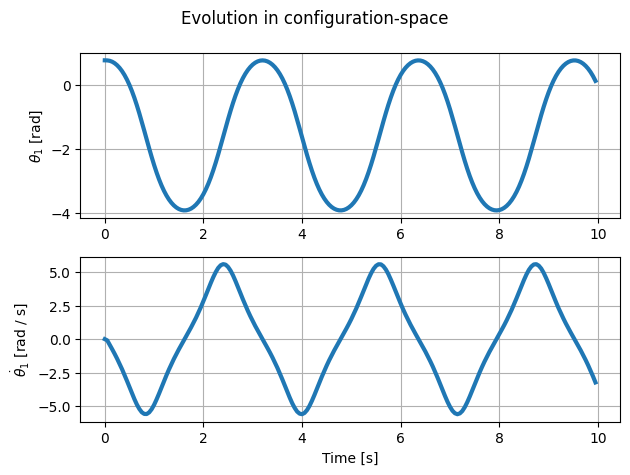

In [26]:
# plot the evolution of the single pendulum in configuration space
plot_configuration_space_evolution(
    sim_ts,
    filepath=str(
        outputs_dir / "task_3-10_autonomous_configuration_space_evolution.pdf"
    ),
)

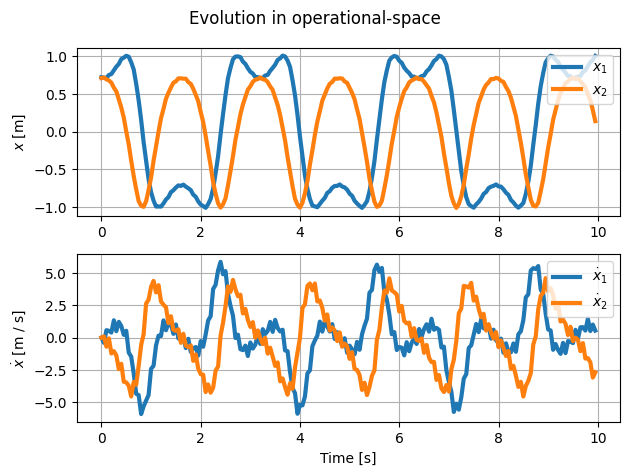

In [27]:
# plot the evolution of the single pendulum in operational space
plot_operational_space_evolution(
    sim_ts,
    filepath=str(outputs_dir / "task_3-10_autonomous_operational_space_evolution.pdf"),
)

In [28]:
if not AUTOGRADING:
    from IPython.display import display, HTML  # For animations in the notebook

    ani = animate_robot(
        ROBOT_PARAMS_SINGLE,
        sim_ts=sim_ts,
        step_skip=2,
        show=False,
        filepath=str(outputs_dir / "task_3-10_autonomous_robot.mp4"),
    )
    display(HTML(ani.to_html5_video()))

### Task 3.10.2: Implement the RL step function (4p)

In this section, you should implement one of the RL training.

1. Take the action
2. Simulate the step using the `discrete_forward_dynamics`
3. Observe the reward of the state-action pair
4. Sample a new action
5. Update the Q table

In [28]:
# import double pendulum forward dynamics
from jax_double_pendulum.dynamics import discrete_forward_dynamics


@jit
def run_rl_step(
    Q: Array,
    dt: float,
    x: Array,
    s: Array,
    a: Array,
    cum_r: float,
    rp: Dict[str, Array],
    par: Dict,
    rng: random.KeyArray,
) -> Tuple[Array, Array, Array, Array, float, random.KeyArray]:
    """
    Run one RL step
    Args:
        Q: Q table of shape (N, M, O)
        dt: time step of simulation [s]
        x: state in the continuous domain as array of shape (2, )
        s: discrete state as array of shape (2, )
        a: discrete action as array of shape ()
        cum_r: cumulative reward
        rp: dictionary with robot parameters
        par: dictionary with RL parameters
        rng: PRNG key for pseudo-random number generation.
    Returns:
        Q: updated Q table of shape (N, M, O)
        xP: next state in the continuous domain as array of shape (2, )
        sP: next discrete state as array of shape (2, )
        aP: next discrete action as array of shape ()
        cum_r: updated cumulative reward
        rng: updated PRNG key for pseudo-random number generation.
    """

    # YOUR CODE HERE
    tau = convert_action_to_torque(a, par)
    th_curr = jnp.array((x[0], 0))
    th_d_curr = jnp.array((x[1], 0))
    th_nxt, th_d_nxt, _ = discrete_forward_dynamics(rp, dt, th_curr, th_d_curr, tau)
    
    # build new state
    xP = jnp.array((th_nxt[0], th_d_nxt[0]))
    sP = discretize_state(xP, par)

    # calculate reward and new action
    r = observe_reward(a, sP, par)
    aP, rng = evaluate_policy(Q, sP, par, rng)

    # update Q
    Q = update_Q(Q, s, a, r, sP, aP, par)

    # Keep track of cumulative reward
    cum_r = cum_r + r

    return Q, xP, sP, aP, cum_r, rng

### Task 3.10.3: Run the RL training (6p)

In this section, you should implement the whole simulation by using the function for a single step. As the `run_rl_step` function is compiled using `jit` it should run faster than native Python. Each episode should contain the following steps:

1. **Optional:** Decay the exploration parameter `epsilon`.
2. Randomly initialize the state (i.e. position and velocity) of the pendulum.
3. Evaluate the policy at the current state.
4. Simulate the system for `num_steps`. At each step, execute `run_rl_step` and evaluate the terminal condition to decide if the episode should be stopped.

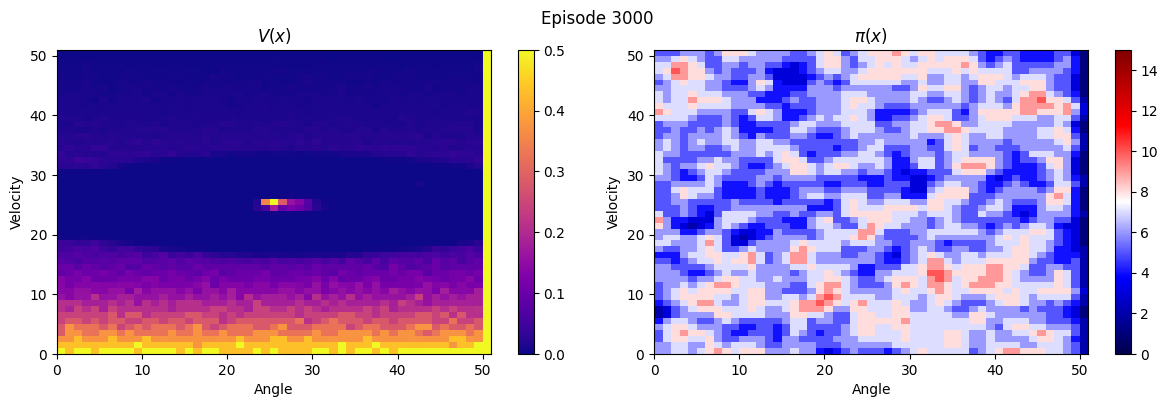

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

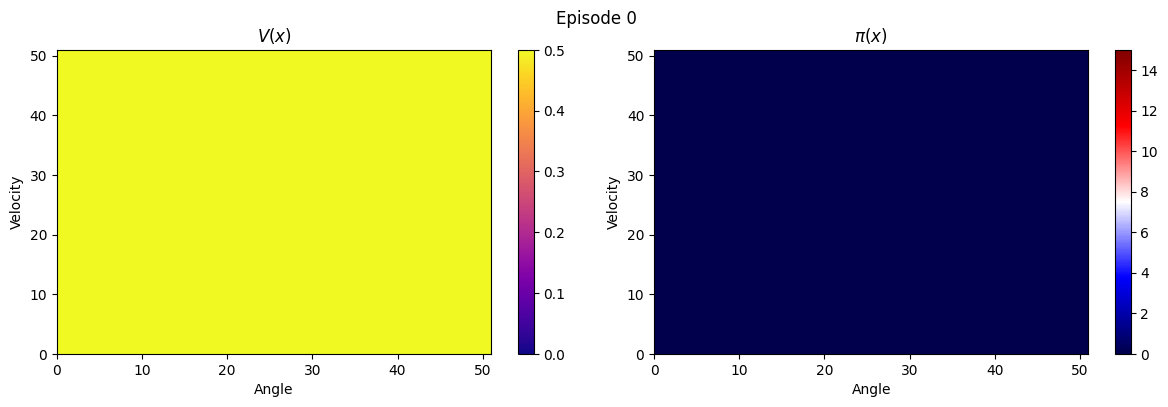

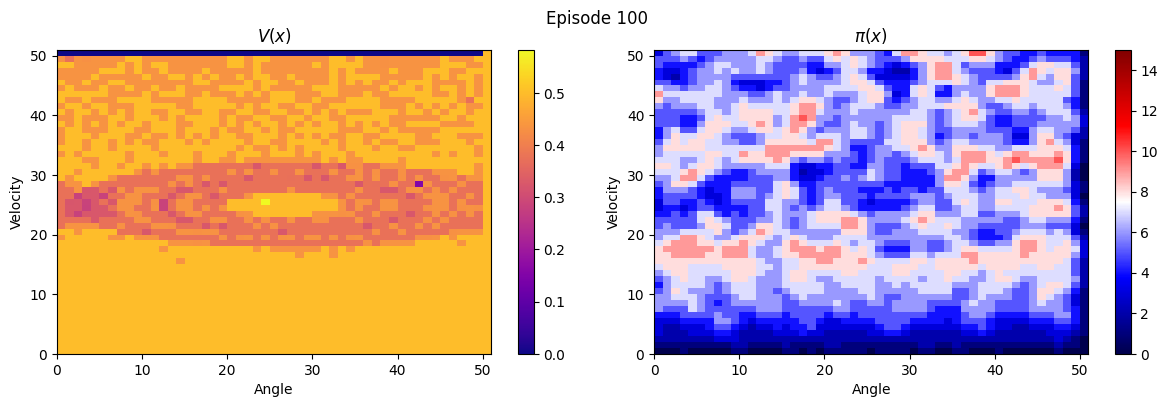

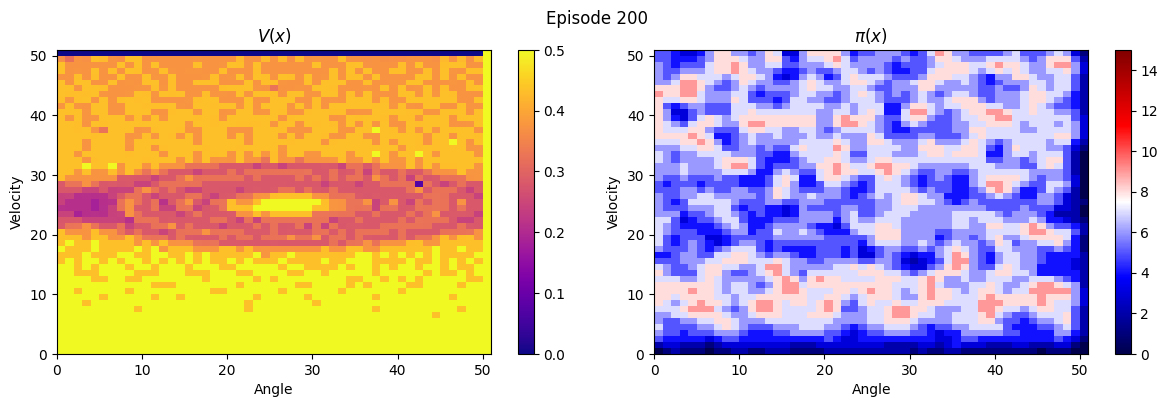

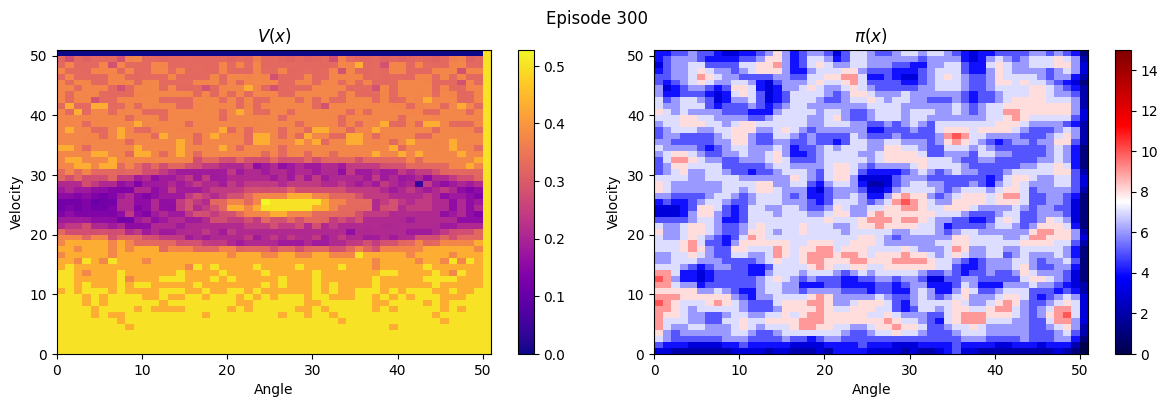

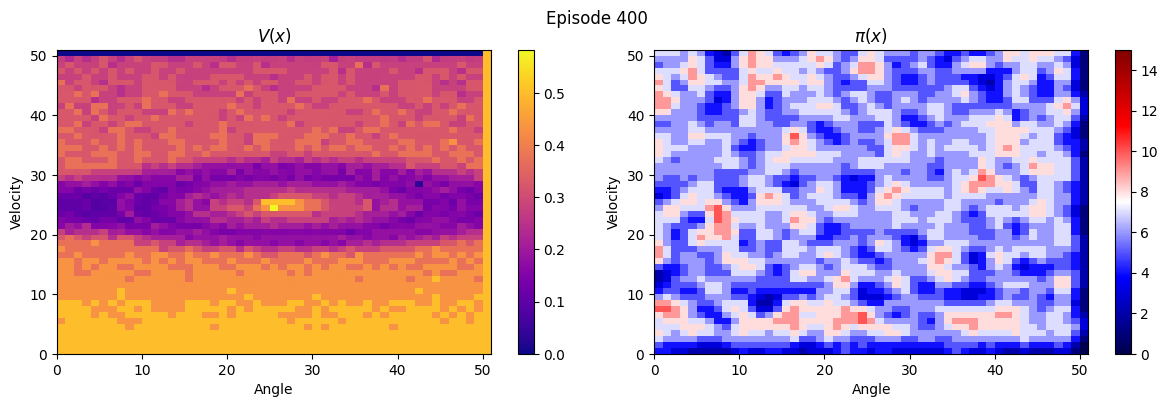

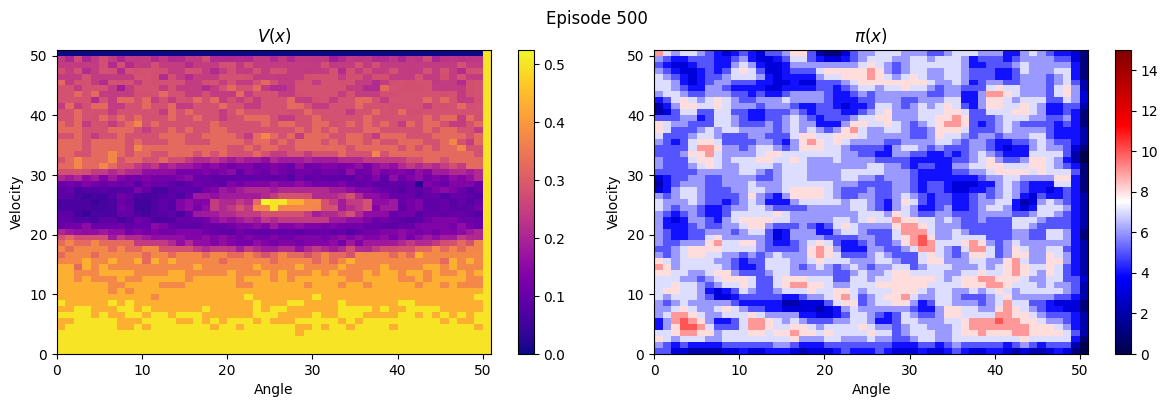

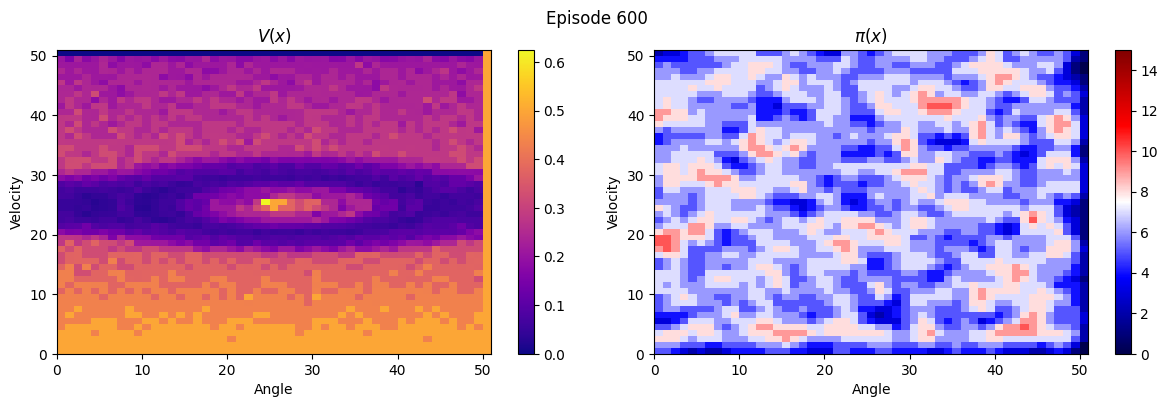

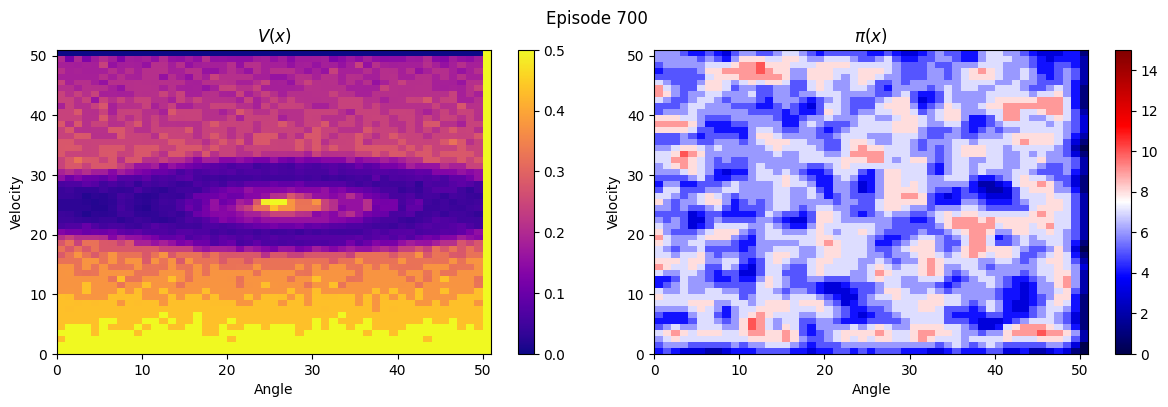

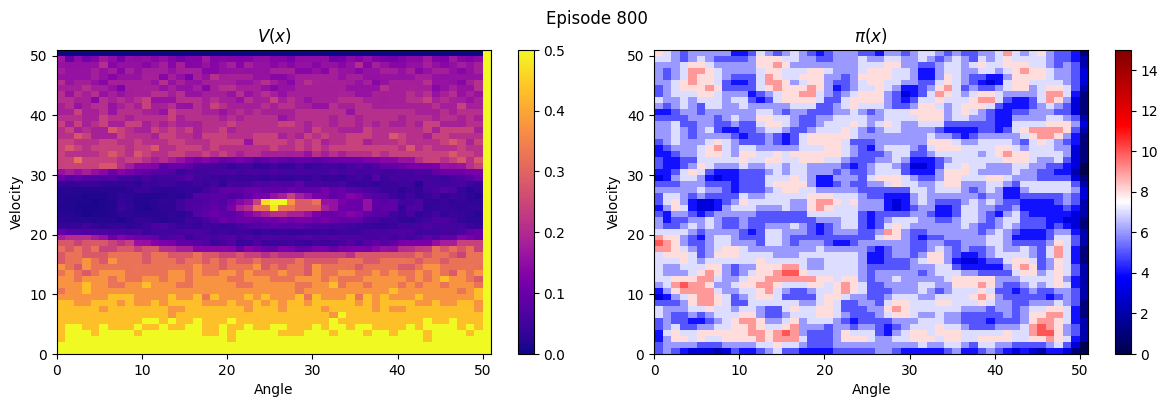

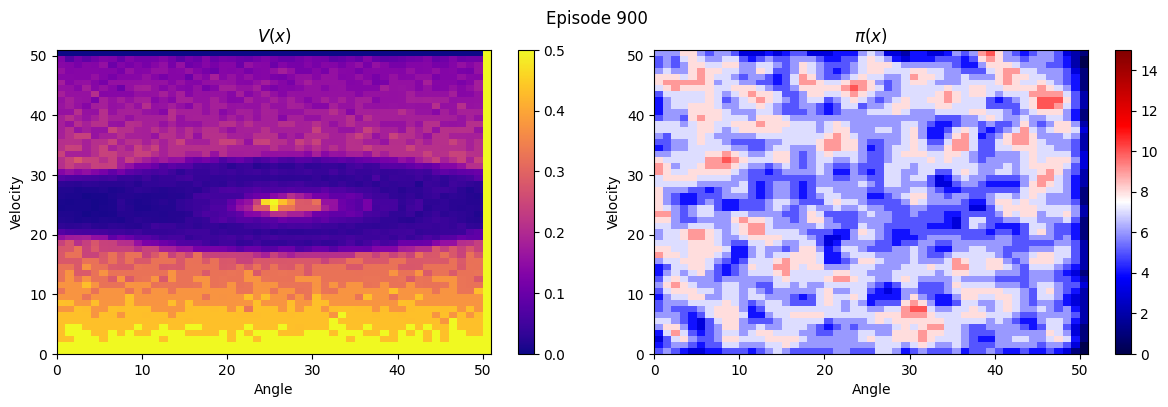

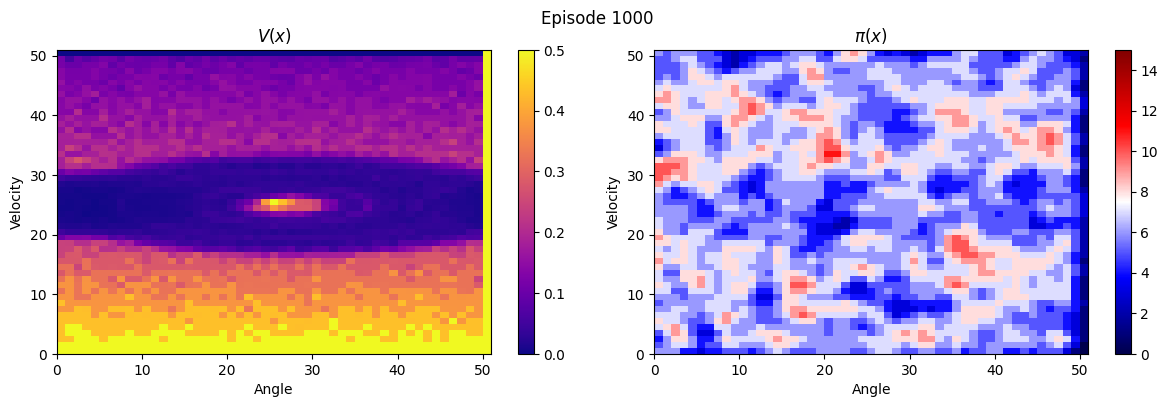

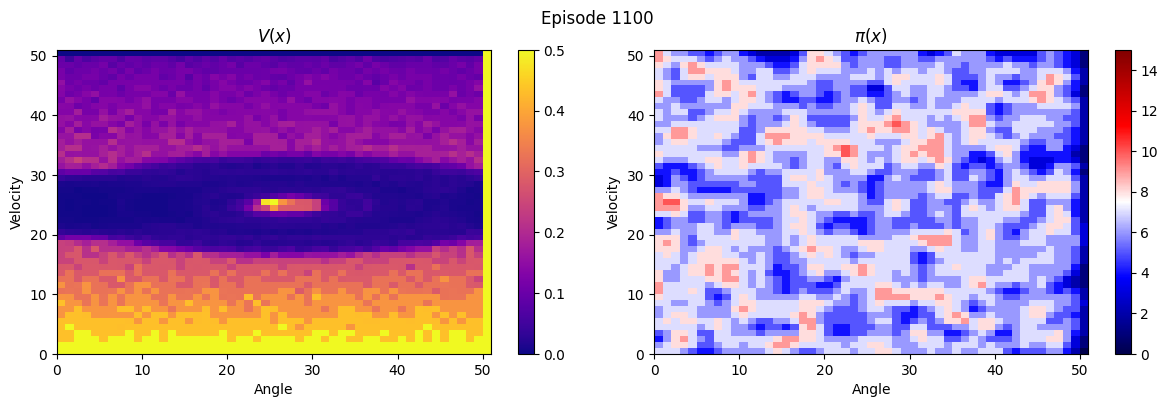

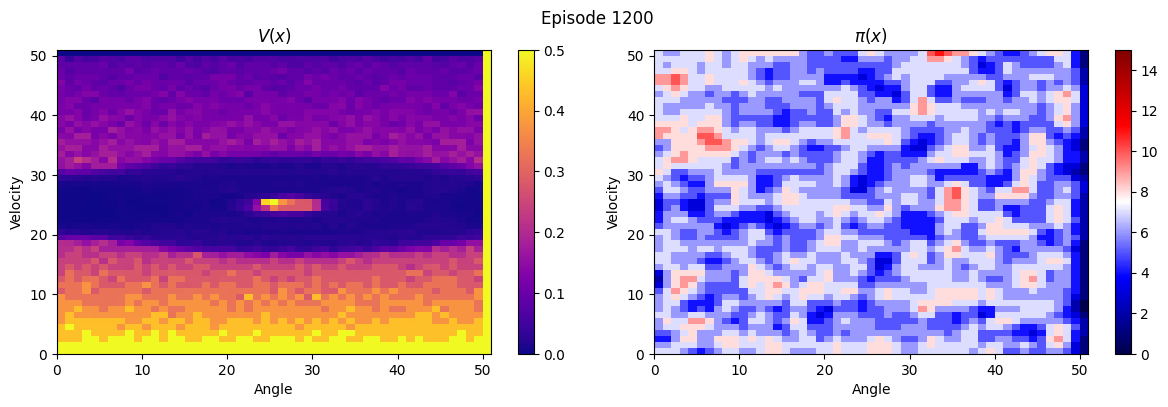

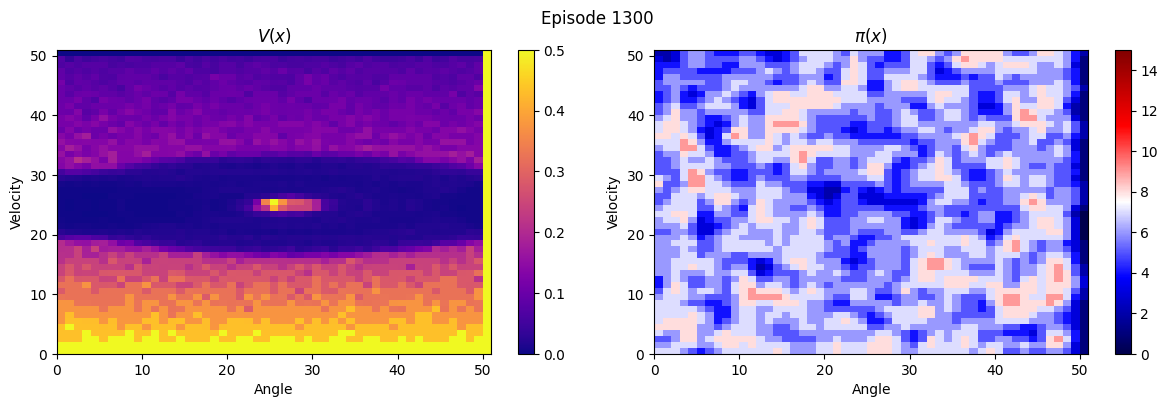

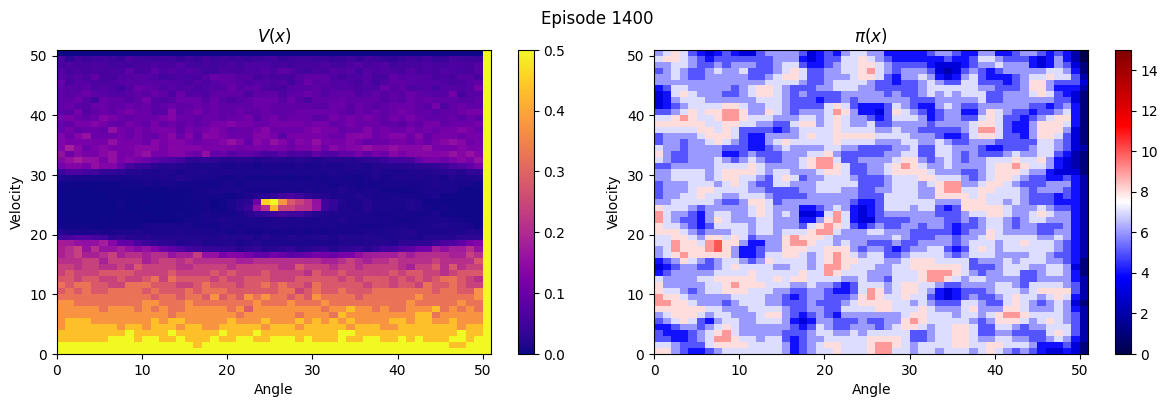

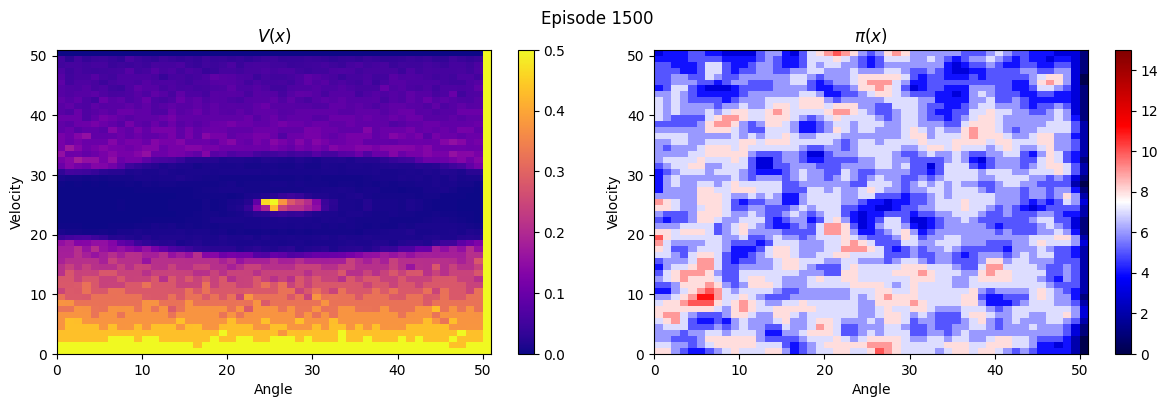

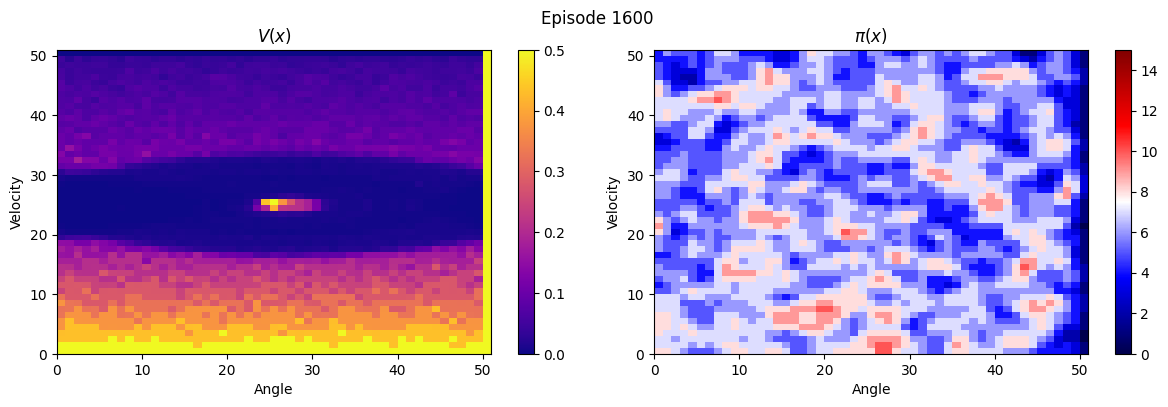

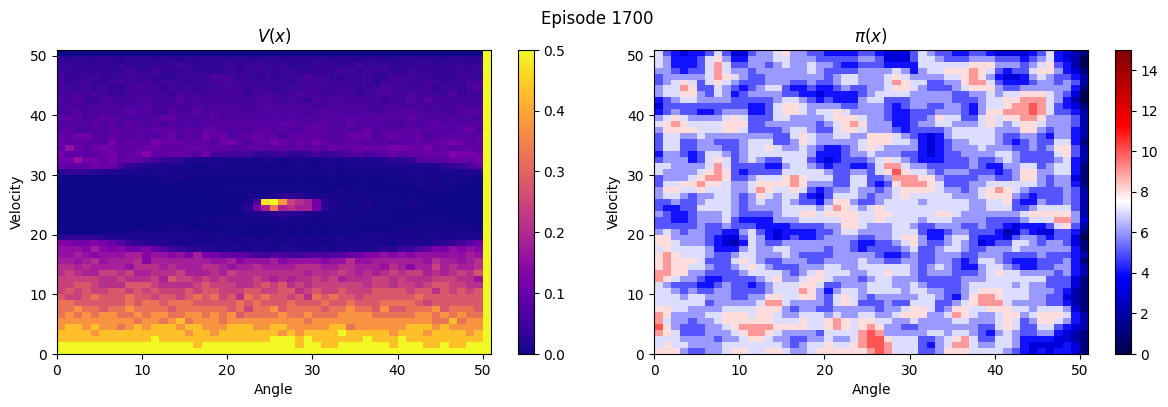

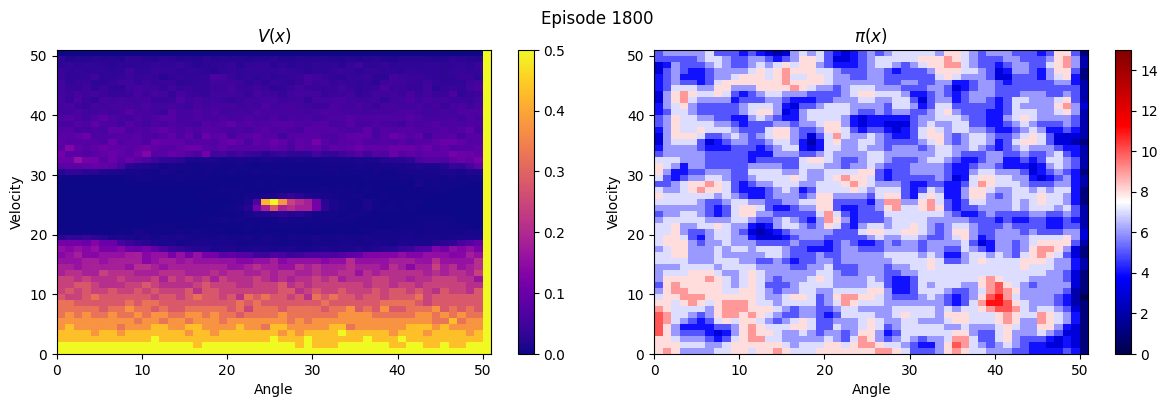

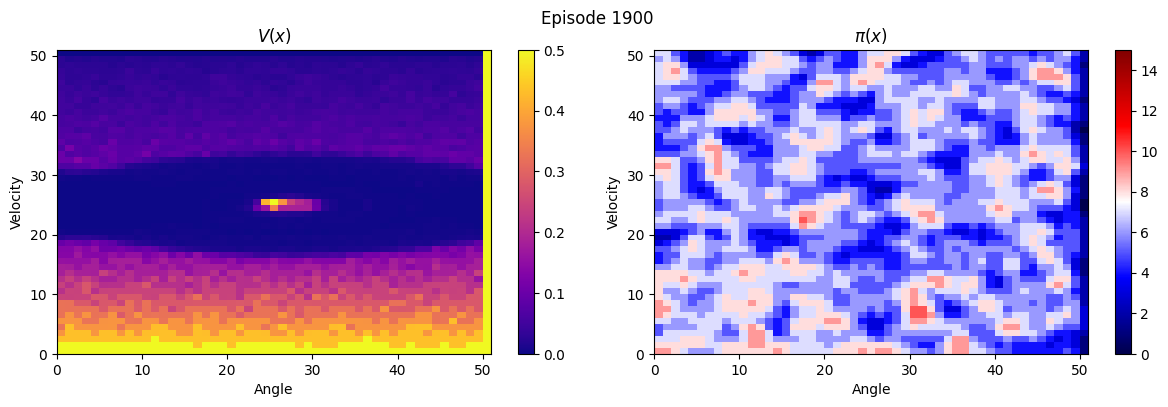

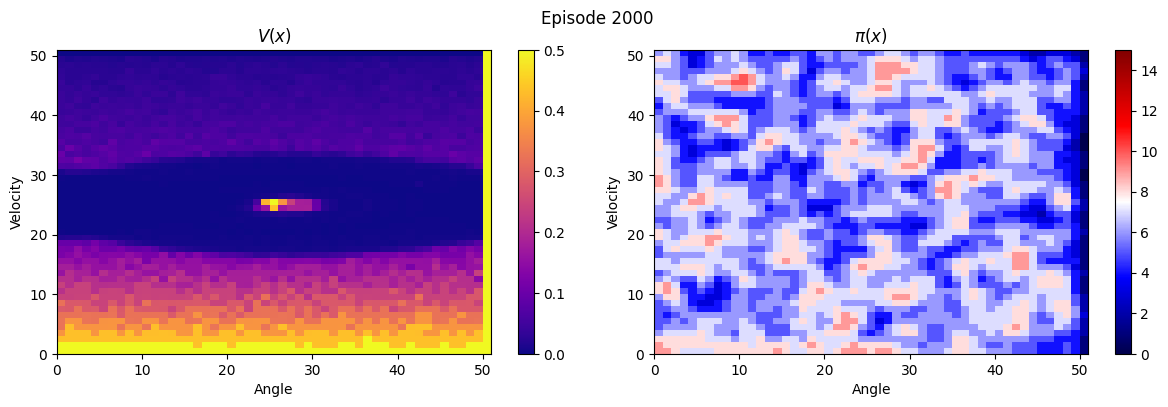

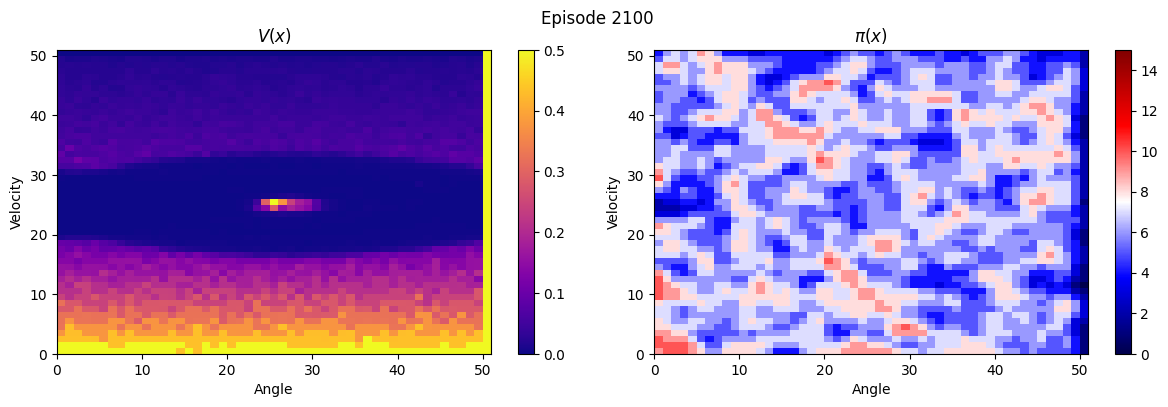

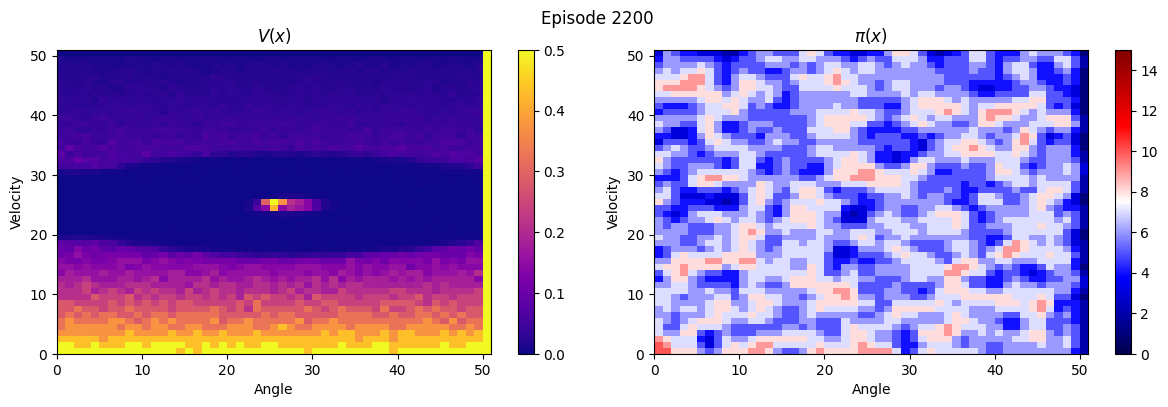

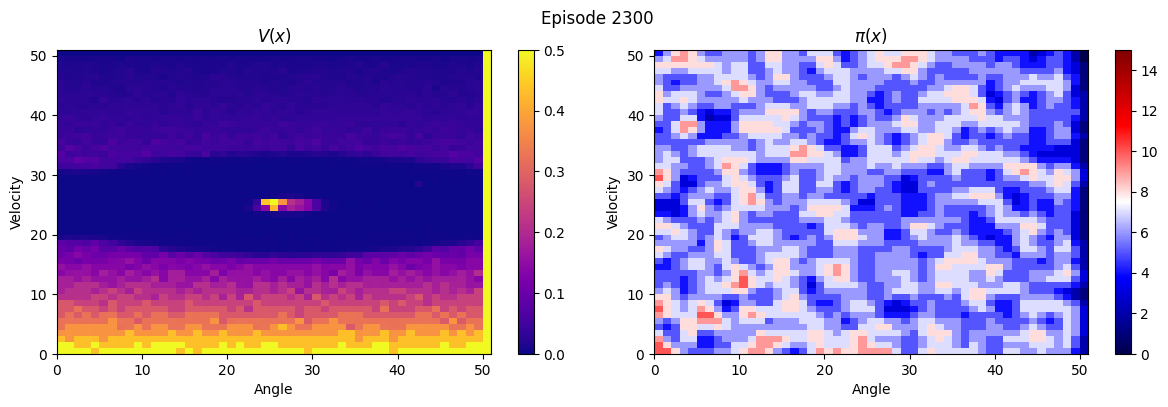

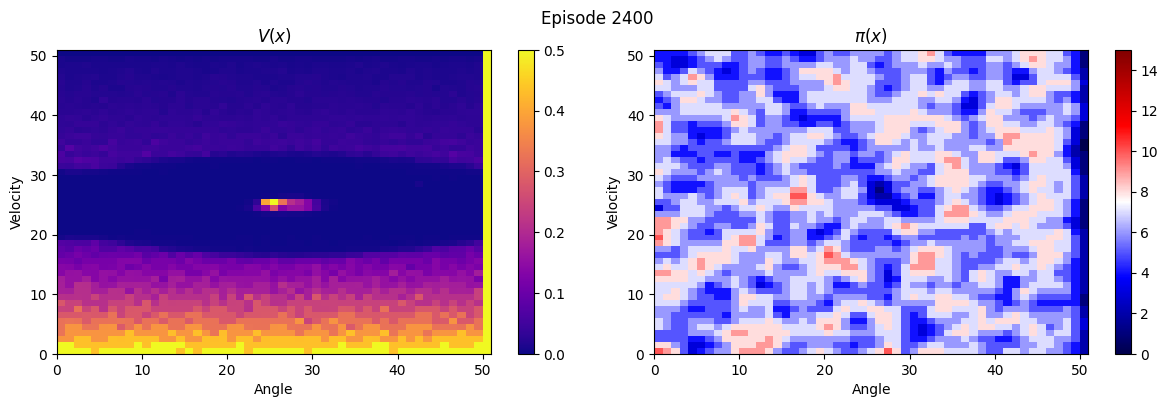

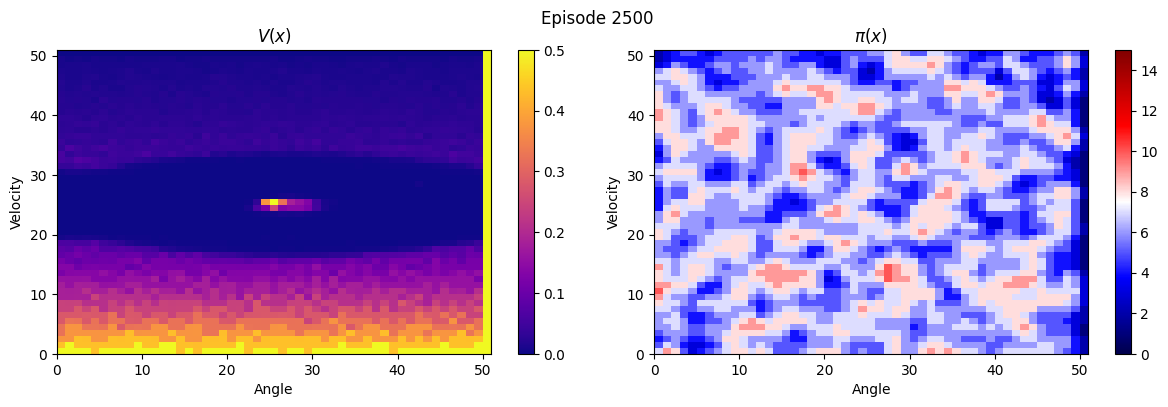

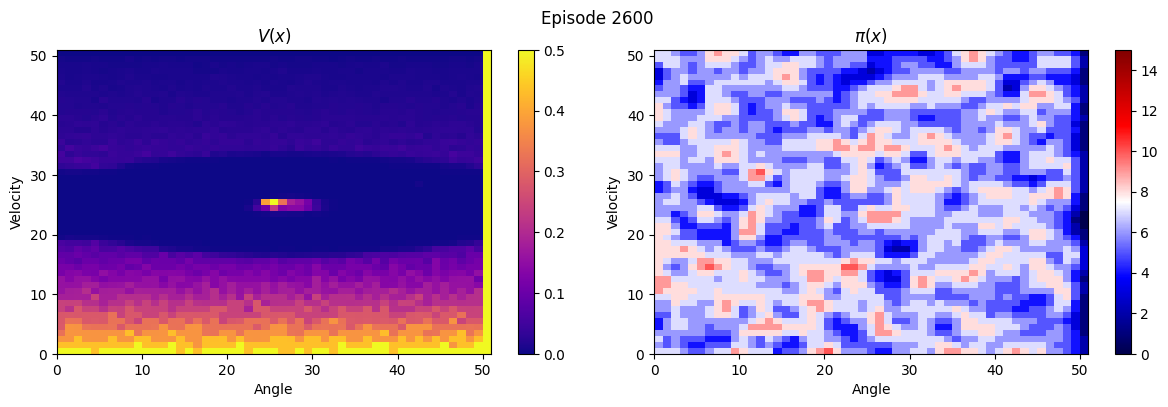

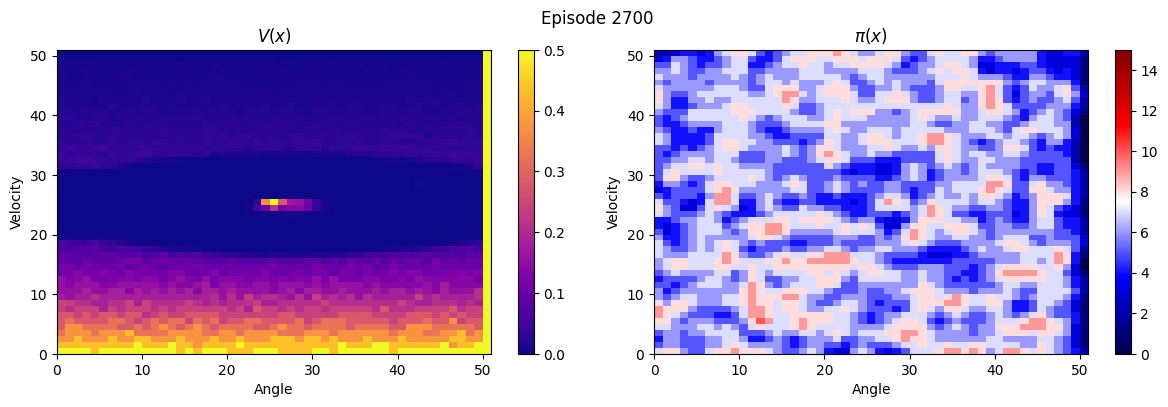

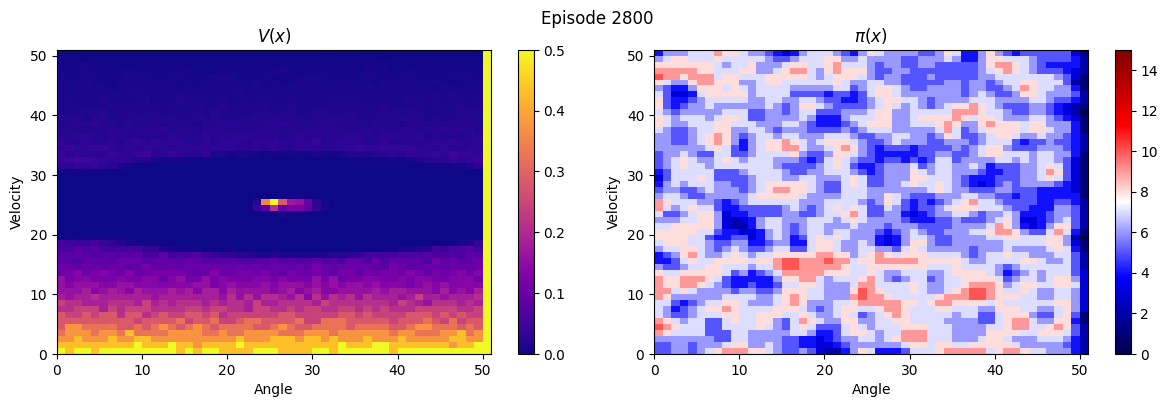

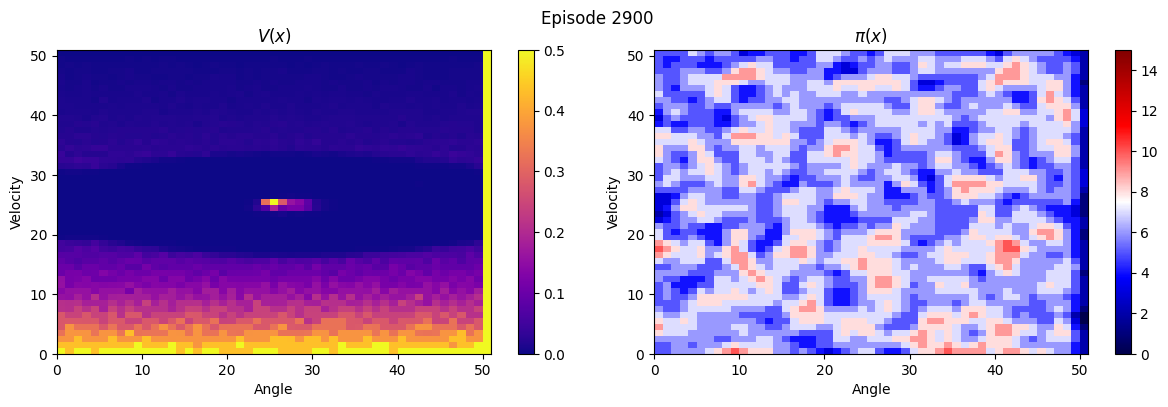

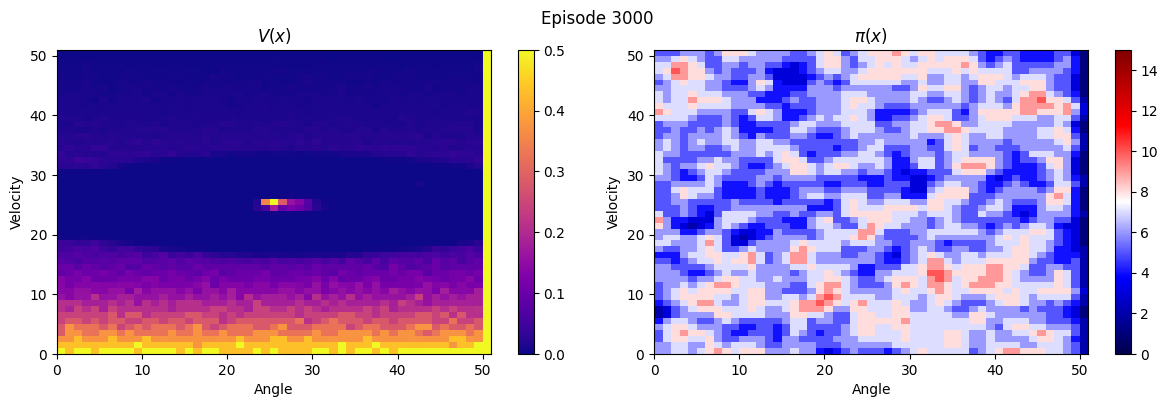

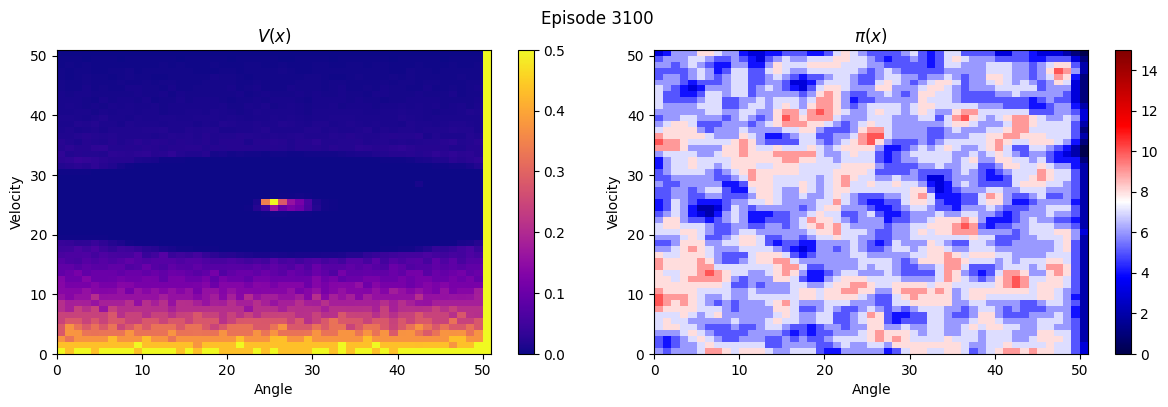

In [29]:
from IPython import display

# simulation parameters
sim_duration = 50.0  # [s]

# define the number of steps
num_steps = int(sim_duration / dt)
t_ts = dt * jnp.arange(num_steps)

# initialize the PRNG key for random number generation
key = random.PRNGKey(548815)

# copy the `SARSA_PARAMS`
par = SARSA_PARAMS.copy()

# initialize Q table
Q = init_Q(SARSA_PARAMS)

# Initialize bookkeeping (for plotting only)
ra = jnp.zeros((par["episodes"],))  # cumulative reward
tta = jnp.zeros((par["episodes"],))  # duration of each episode
te = 0

# Outer loop: episodes
for ii in range(par["episodes"]):
    # Update plot every 100 episodes
    if jnp.mod(ii, 100) == 0:
        display.clear_output(wait=True)  # for updating plot
        display.display(plt.gcf())  # for updating plot
        plot_theta_theta_d(Q, par, suptitle="Episode %i" % ii)

    # YOUR CODE HERE

    # decrease epsilon
    # par["epsilon"]=0.99*par["epsilon"]

    # initial state
    x, key = sample_initial_state(key)
    s = discretize_state(x0, par)

    # evaluate policy
    a, key = evaluate_policy(Q, s, par, key)

    # run RL step
    cum_r = 0
    for tt in range(num_steps):
        Q, x, s, a, cum_r, rng = run_rl_step(Q, dt, x, s, a, cum_r, ROBOT_PARAMS_SINGLE, par, key)
        if is_terminal(s, par):
            break

    # Keep track of cumulative reward and time of each episode
    ra = ra.at[ii].set(cum_r)
    tta = tta.at[ii].set(tt * dt)

# save the last plot
plt.savefig(
    str(outputs_dir / "task_3-10-3_value_and_policy_function_after_training.pdf")
)

In [31]:
# create the `statedicts` folder
statedict_dir = Path("statedicts")
statedict_dir.mkdir(parents=True, exist_ok=True)

# save Q to checkpoints
Q_trained = Q

# save the trained Q table
jnp.save(str(statedict_dir / "task_3-10-3_trained_Q_table.npy"), Q_trained)

## Task 3.11 - Inference & analysis (9p)

### Task 3.11.1: Plotting of cumulative reward and episode duration

First, please plot the evolution of the cumulative reward and the duration of a epsiode over the training process. **Hint:** Implement a moving average / running mean to reduce the noise in the plot and make later analysis easier.

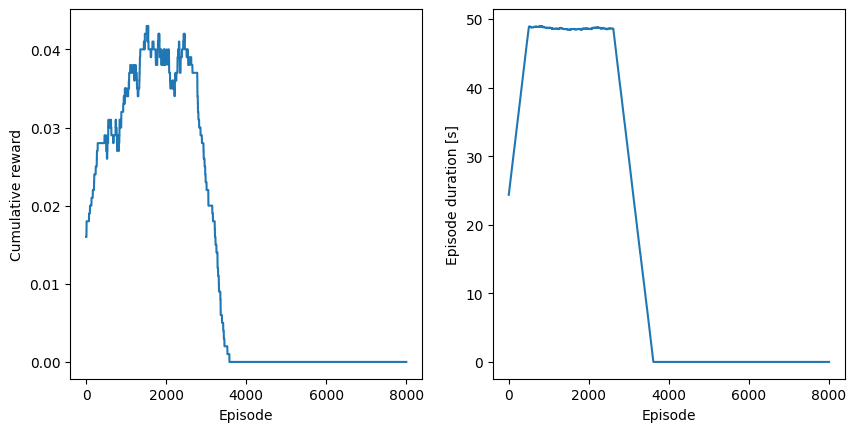

In [32]:
# now we analyse the cumulative reward and the episode duration as a function of the episode


# Hint: implement a function to compute the moving average,
# which makes it easier to detect trends
# YOUR CODE HERE
n = 1000
r_avg = jnp.convolve(ra, jnp.ones(n)/n, "same")
t_avg = jnp.convolve(tta, jnp.ones(n)/n, "same")
eps = jnp.arange(par["episodes"])
# we make two subplots
# 1. Left: plot the cumulative reward (y-axis) vs. the episode (x-axis)
# 2. Right: plot the episode duration [s] (y-axis) vs. the episode (x-axis)
plt.figure(figsize=(10.0, 4.8))

plt.subplot(1, 2, 1)
# YOUR CODE HERE
plt.plot(eps, r_avg)
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")

plt.subplot(1, 2, 2)
# YOUR CODE HERE
plt.plot(eps, t_avg)
plt.xlabel("Episode")
plt.ylabel("Episode duration [s]")

# save the plot
plt.savefig(str(outputs_dir / "task_3-11-1_cumulative_reward_and_episode_duration.pdf"))

### Task 3.11.2: Use the trained policy for closed-loop control (3p)

Now, its time to use the trained policy for closed-loop control of the single pendulum. Please make sure that any exploration is deactivated. First, implement a feedback controller below, which uses the trained RL policy to compute a torque to be applied to the pendulum

In [33]:
@jit
def ctrl_fb_rl(
    th: Array,
    th_d: Array,
    th_des: Array,
    th_d_des: Array,
    Q: Array,
    par: Dict,
    rng: random.KeyArray,
) -> Array:
    """
    RL controller
    Args:
         th: joint angles [rad] of shape (2, )
         th_d: joint velocities [rad/s] of shape (2, )
         th_des: desired joint angles [rad] of shape (2, )
         th_d_des: desired joint velocities [rad/s] of shape (2, )
         Q: trained Q table of shape (N, M, O)
         par: dictionary with RL parameters
         rng: PRNG key for pseudo-random number generation.
     Returns:
         tau: Torques [Nm] to be applied to the pendulum links computed by the RL controller of shape (2, )
    """
    # YOUR CODE HERE

    x = jnp.array((th[0], th_d[0]))
    s = discretize_state(x, par)
    a = evaluate_policy(Q, s, par, rng)
    torque = convert_action_to_torque(a, par)

    tau = jnp.array([torque, 0.0])

    return tau

In [34]:
SARSA_PAR_INFERENCE = SARSA_PARAMS.copy()
# deactivate exploration for inference
SARSA_PAR_INFERENCE["explore"] = False

# set the random seed (shouldn't be used by code, but interface requires it)
key = random.PRNGKey(548815)

# set the initial conditions
th_0 = jnp.array([-0.5 * jnp.pi / 2, 0.0])
th_d_0 = jnp.array([0.0, 0.0])

# define duration of simulation
sim_duration = 20.0  # [s]
t_ts = dt * jnp.arange(int(sim_duration / dt))

In [35]:
# setup the RL controller
# the final RL control law needs to conform to the interface:
#   ctrl_fb_fn(th, th_d, th_des, th_d_des) -> tau
# Hint: make use of `partial`
# YOUR CODE HERE
ctrl_fb_fn = partial(ctrl_fb_rl, Q=Q, par=SARSA_PAR_INFERENCE, rng=key)

In [36]:
# simulate the robot
sim_ts = simulate_robot(
    rp=ROBOT_PARAMS_SINGLE,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=th_d_0,
    th_des_ts=jnp.pi / 2 * jnp.ones((t_ts.shape[0], 2)),
    th_d_des_ts=jnp.zeros((t_ts.shape[0], 2)),
    ctrl_fb=ctrl_fb_fn,
)

TypeError: interp requires ndarray or scalar arguments, got <class 'tuple'> at position 0.

In [ ]:
# plot the evolution of the single pendulum in configuration space
plot_configuration_space_evolution(
    sim_ts,
    filepath=str(
        outputs_dir / "task_3-11-2_controllled_configuration_space_evolution.pdf"
    ),
)

In [ ]:
# plot the evolution of the single pendulum in operational space
plot_operational_space_evolution(
    sim_ts,
    filepath=str(
        outputs_dir / "task_3-11-2_controlled_operational_space_evolution.pdf"
    ),
)

In [ ]:
if not AUTOGRADING:
    from IPython.display import display, HTML  # For animations in the notebook

    ani = animate_robot(
        ROBOT_PARAMS_SINGLE,
        sim_ts=sim_ts,
        step_skip=2,
        show=False,
        filepath=str(outputs_dir / "task_3-11-2_controlled_robot.mp4"),
    )
    display(HTML(ani.to_html5_video()))

### Task 3.11.3 Analysis of the RL training (4p)

Analyze:
- How many simulation steps on average does a swing-up take (after learning has finished)? Will it
be wise to reduce the number of steps per trial during learning?
- Large parts of the policy in the policy graph are quite noisy. What reasons can you name?
- Test your code with greedy and ε-greedy policies. Which method allows the algorithm to converge
faster and which method results in a higher cumulative reward (on average)? Can SARSA converge with constant ε? Explain the reason.
- Try several values of the discount rate, spanned across the [0, 1) interval. What discount rate allows
the algorithm to converge faster? Explain the reason.
- Is your policy capabale of swinging up the pendulum? Is your policy capable of stabilizing the pendulum at the top? What can be changed in the training to improve capabilities?

Write up your observations as bulletpoints (maximum 200 words)